In [1]:
######### 기본세팅 ###### 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 새로운 창이 아닌 기존창에서 결과를 확인하기 위한 입력
%matplotlib inline

df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [2]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
df_test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [4]:
# test에는 survived 컬럼이 없다. 참고
print(df_train.shape, df_test.shape)
print(df_train.columns, '\n', df_test.columns)

(891, 12) (418, 11)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') 
 Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [6]:
# null 어떻게 처리할지랑, object형 어떻게 처리할지(원핫인코딩을 쓰자) 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
### 1) 가장먼저할일: null 체크
# Age, cabin이 공통, embarked는 train에만, fare는 test만
print(df_train.isnull().sum(), '\n')
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [8]:
## 피쳐 엔지니어링
# familysize로 피처 통합
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

# Fare부분 빈칸 채우고, skewed 되어있으니 log를 씌우기, train은 안비어있으니 test만 조정
# df_test.loc[df_test['Fare'].isnull(), 'Fare'] = df_test['Fare'].mean()
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace=True)

df_train['Fare'] = df_train['Fare'].map(lambda x: np.log(x) if x >0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda x: np.log(x) if x >0 else 0)

In [9]:
# age를 어떻게 채울 것이냐, 그냥 mean으로 넣을 수도 있겠지만, 이름을 가지고 한번 분석해보자
# mr., mrs. 만 추출해서 비교해보면 어떨까? 
# pandas 한정 Series에서 str.extract 하면 원하는 위치를 떼어준다. 여기서는 .으로 구분된 부분만 추출
df_train['Initial'] = df_train['Name'].str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test['Name'].str.extract('([A-Za-z]+)\.')

In [10]:
# initial 기준으로 master, miss, mr, mrs 정도만 유의미하고 나머지는 other로 변경
pd.crosstab(df_train['Sex'], df_train['Initial'])

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [11]:
df_train['Initial'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major','Master','Miss','Mlle','Mme','Mr','Mrs','Ms','Rev','Sir'],
                           ['Mr', 'Mr', 'Miss', 'Mr', 'Other', 'Mr','Mrs','Mr','Master','Miss','Miss','Miss','Mr','Mrs','Miss','Mr','Mr'], inplace=True)

In [12]:
pd.crosstab(df_train['Sex'], df_train['Initial'])

Initial,Master,Miss,Mr,Mrs,Other
Sex,,,,,
female,0,187,0,126,1
male,40,0,531,0,6


In [ ]:
# 하나씩 바꿔가기, 바꿀때 이렇게 확인
df_train[df_train['Initial']=='Master'].head(3)

In [13]:
pd.crosstab(df_test['Sex'], df_test['Initial'])

Initial,Col,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
Sex,,,,,,,,,
female,0,1,0,0,78,0,72,1,0
male,2,0,1,21,0,240,0,0,2


In [14]:
df_test['Initial'].replace(['Col','Dona','Dr','Master','Miss','Mr','Mrs','Ms','Rev'],
                            ['Mr','Miss','Other','Master','Miss','Mr','Mrs','Miss','Mr'], inplace=True)

In [ ]:
df_test[df_test['Initial']=='Dona']

In [15]:
pd.crosstab(df_test['Sex'], df_test['Initial'])

Initial,Master,Miss,Mr,Mrs,Other
Sex,,,,,
female,0,80,0,72,0
male,21,0,244,0,1


In [16]:
# Avg age: Master 5, Miss 22, Mr 33, Mrs 36, Other 42
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,413.604278,0.705882,2.278075,21.933775,0.695187,0.534759,3.130860,2.229947
Mr,456.534840,0.158192,2.384181,32.891990,0.286252,0.152542,2.639707,1.438795
Mrs,453.984127,0.793651,1.992063,36.009174,0.698413,0.825397,3.435684,2.523810
Other,545.857143,0.428571,1.285714,42.000000,0.571429,0.000000,3.533913,1.571429


In [17]:
# Avg age: Master 7, Miss 22, Mr 32, Mrs 39, Other 53
df_test.groupby('Initial').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,
Master,1123.380952,2.714286,7.406471,1.571429,1.380952,3.112730,3.952381
Miss,1102.812500,2.425000,22.039846,0.537500,0.387500,2.949562,1.925000
Mr,1100.495902,2.307377,32.229947,0.274590,0.176230,2.744583,1.450820
Mrs,1090.097222,1.833333,38.903226,0.597222,0.833333,3.566570,2.430556
Other,1185.000000,1.000000,53.000000,1.000000,1.000000,4.404990,3.000000


In [18]:
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial'] == 'Master'), 'Age'] = 5
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial'] == 'Miss'), 'Age'] = 22
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial'] == 'Mr'), 'Age'] = 33
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial'] == 'Mrs'), 'Age'] = 36
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial'] == 'Other'), 'Age'] = 42

df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial'] == 'Master'), 'Age'] = 7
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial'] == 'Miss'), 'Age'] = 22
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial'] == 'Mr'), 'Age'] = 32
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial'] == 'Mrs'), 'Age'] = 39
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial'] == 'Other'), 'Age'] = 53

In [19]:
print(df_train.isnull().sum())
print()
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FamilySize       0
Initial          0
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
FamilySize       0
Initial          0
dtype: int64


In [20]:
# Embarked 채우기
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [21]:
# 아 그냥 s로 몰자 몇개 없는데
df_train['Embarked'].fillna('S', inplace=True)

In [22]:
## Cabin 어떻게 할지, cabin은 null 이 너무 많기도 하고 불필요한 컬럼으로 보임, 걍 나중에 컬럼 날리자
df_train['Cabin']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  FamilySize   891 non-null    int64  
 13  Initial      891 non-null    object 
dtypes: float64(2), int64(6), object(6)
memory usage: 97.6+ KB


In [24]:
# 원핫인코딩으로 initial,sex, embarked를 대체하는 모습
# name, ticket, cabin은 안쓸거라서 아무짓도 안한것임
df_train = pd.get_dummies(df_train, columns=['Initial', 'Sex', 'Embarked'], prefix=['Initial', 'Sex', 'Embarked'])

In [25]:
df_test = pd.get_dummies(df_test, columns=['Initial', 'Sex', 'Embarked'], prefix=['Initial', 'Sex', 'Embarked'])

In [26]:
# 안쓰는 컬럼들 제거 및 덮어쓰기
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    int64  
 1   Pclass          891 non-null    int64  
 2   Age             891 non-null    float64
 3   Fare            891 non-null    float64
 4   FamilySize      891 non-null    int64  
 5   Initial_Master  891 non-null    uint8  
 6   Initial_Miss    891 non-null    uint8  
 7   Initial_Mr      891 non-null    uint8  
 8   Initial_Mrs     891 non-null    uint8  
 9   Initial_Other   891 non-null    uint8  
 10  Sex_female      891 non-null    uint8  
 11  Sex_male        891 non-null    uint8  
 12  Embarked_C      891 non-null    uint8  
 13  Embarked_Q      891 non-null    uint8  
 14  Embarked_S      891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(10)
memory usage: 43.6 KB


In [28]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pclass          418 non-null    int64  
 1   Age             418 non-null    float64
 2   Fare            418 non-null    float64
 3   FamilySize      418 non-null    int64  
 4   Initial_Master  418 non-null    uint8  
 5   Initial_Miss    418 non-null    uint8  
 6   Initial_Mr      418 non-null    uint8  
 7   Initial_Mrs     418 non-null    uint8  
 8   Initial_Other   418 non-null    uint8  
 9   Sex_female      418 non-null    uint8  
 10  Sex_male        418 non-null    uint8  
 11  Embarked_C      418 non-null    uint8  
 12  Embarked_Q      418 non-null    uint8  
 13  Embarked_S      418 non-null    uint8  
dtypes: float64(2), int64(2), uint8(10)
memory usage: 17.3 KB


In [29]:
### 드디어 전처리가 끝났습니다. 
# 이제 머신러닝을 돌려봅시다.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [30]:
# train set에서도 한번 나눠서 Valid set를 추가한 후 검증을 하고, 제출을 test set으로 한다. 
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [31]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

In [33]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_tr, y_tr)
rf_predict = rf_clf.predict(X_vld)

In [34]:
accuracy_score(y_vld, rf_predict)

0.832089552238806

In [35]:
feature_importance = rf_clf.feature_importances_
series_feat_imp = pd.Series(feature_importance, index=df_test.columns)

<AxesSubplot:>

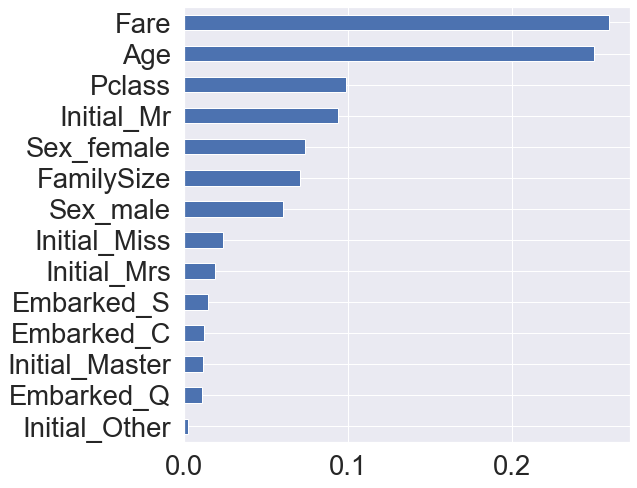

In [36]:
plt.figure(figsize=(8,8))
series_feat_imp.sort_values().plot.barh()

In [37]:
submission = pd.read_csv('./gender_submission.csv')

In [38]:
rf_test_predict = rf_clf.predict(X_test)

In [39]:
submission['Survived'] = rf_test_predict

In [40]:
submission.to_csv('./my_second_submission.csv', index=False)